In [1]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')
sys.path.append("neuroformer")

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io

from utils import *

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
from utils import set_seed
set_seed(25)

In [4]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

train_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff"
vid_list = [skimage.io.imread(vid) for vid in sorted(glob.glob(train_path + '/*.tif'))]
print(glob.glob(train_path + '/*.tif')[::-1])
video_stack = np.concatenate(vid_list, axis=0, dtype=np.float32)


# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
video_stack = torch.nan_to_num(video_stack)
# # video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

['/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/videoplayback_clip1.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/Beaver Documentary_clip3.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/Plants Communicate_clip1.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/Lviv_clip1.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/A Perfect Blend of Five Flavors_clip1.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/Beaver Documentary_clip1.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/A Perfect Blend of Five Flavors_clip2.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/stimulus/tiff/Beaver Documentary_clip2.tif']
im_sack size: torch.Size([163965, 1, 64, 112])


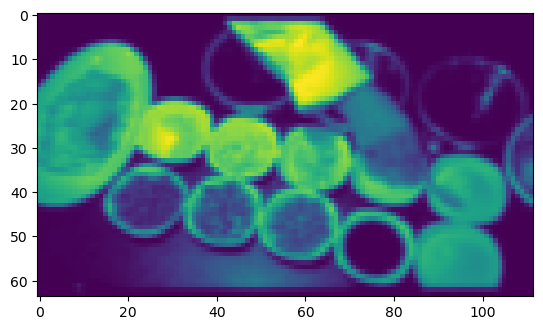

In [5]:
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.show()

In [6]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_real

spike_data = scipyio.loadmat("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A/20-NatureMovie_part1-A_spikes(1).mat")
spike_data = trial_df_real(np.squeeze(spike_data['spiketrain']['st'].T, axis=-1))
spike_data = spike_data[spike_data['Time'] > 0]

vid_duration = [len(vid) * 1/60 for vid in vid_list]

df = spike_data
df['Time'] = df['Time'] * 0.1499
current_time = 0
for idx, trial in enumerate(df['Trial'].unique()):
    df['Time'][df['Trial'] == trial] += current_time
    current_time += vid_duration[idx]    # add duration of last clip
# spike_df = pd.concat(spike_data)

<ipython-input-6-d15b89633483>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'][df['Trial'] == trial] += current_time
/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
# df_sim = pd.read_csv("data/full_sim__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[1:, 1:].reset_index(drop=True)
# df_sim = df_sim[df_sim['ID'] <= 164]
# df_sim['Trial'] = df_sim['Trial'] + df['Trial'].max()
# df = pd.concat([df, df_sim], axis=0)

In [8]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)
df = df[df['Time'] <= 2732]

In [9]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(3)

In [10]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(10)

Interval  Trial
0.5       0        174
1.0       0        166
47.5      0        151
3.5       0        140
274.0     0        139
1749.5    4        135
2257.0    6        134
2256.5    6        132
1750.0    4        129
5.0       0        128
dtype: int64

In [11]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
id_block_size = 176   # 95
prev_id_block_size = id_block_size
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [12]:
df['Trial'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
len(small_data['Interval'].unique())

NameError: name 'small_data' is not defined

In [ ]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = [7]
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([7])].reset_index(drop=True)
small_data = small_data[small_data['Interval'].isin(small_data['Interval'].unique()[:100])]

In [ ]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

In [ ]:
iterable = iter(test_dataset)

In [ ]:
x, y = next(iterable)

In [ ]:
x['id_prev'][:len(x['id_prev']) - x['pad']]

In [ ]:
x['id'][:len(x['id']) - x['pad']]

In [ ]:
y['id'][:len(y['id']) - x['pad']]

In [ ]:
y['dt'][:len(y['id']) - x['pad']]

In [ ]:
x['id'].size()

In [ ]:
x['id'].size() == x['id_prev'].size()

In [ ]:
x['id_prev'].size()

In [ ]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [ ]:
from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=False,
                        n_state_layers=6, n_state_history_layers=6, n_stimulus_layers=6,
                        n_layer=8, n_head=4, n_embd=256,
                        temp_emb=True, pos_emb= True,
                        id_drop=0.1, im_drop=0.1)
model = GPT(mconf)
# model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/neuroformer:False_perceiver_2.0_dt:0.05_eos_(4, 4, 8)_8_256.pt", map_location='cpu'))

In [ ]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_8_4_256.pt"))

In [ ]:
# loader = DataLoader(small_dataset, shuffle=False, pin_memory=False,
#                                   batch_size=1, num_workers=1)
# x, y = next(iter(loader))
# model = model.to('cpu')

# preds, features, loss = model(x, y)

In [ ]:
# tensor(611.5000, device='cuda:0', dtype=torch.float16) tensor(1, device='cuda:0')

In [ ]:
from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))


layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 200
batch_size = 32 * 3
shuffle = True
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=8e-5, 
                      num_workers=4, lr_decay=True, patience=3, warmup_tokens=3e5, 
                      decay_weights=True, shuffle=shuffle,
                      final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                      clip_norm=8.0, grad_norm_clip=2.0,
                      dataset='higher_order', mode='predict',
                      block_size=train_dataset.block_size,
                      id_block_size=train_dataset.id_block_size,
                      show_grads=False, plot_raster=False,
                      ckpt_path=f"/home/antonis/projects/slab/git/neuroformer/models/neuroformer_natmovie_norm_weighted:dt_:{shuffle}_perceiver_2.0_{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt")
# f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
trainer.train()  

In [ ]:
bug_df = df[(df['Interval'].isin([610.5, 611, 611.5]) & df['Trial'].isin([1]))]

In [ ]:
bug_dataset = SpikeTimeVidData2(bug_df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


In [ ]:
loader = DataLoader(bug_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)                   

In [ ]:
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
x['interval']

In [ ]:
print(x['interval'], x['trial'])

In [ ]:
preds, features, loss = model(x, y)

In [ ]:
print(preds)

In [ ]:
df

In [ ]:
x['id_prev']

In [ ]:
x['id'][..., :len(x['id']) - x['pad']]

In [ ]:
y['id'][..., :len(y['id']) - x['pad']]

In [ ]:
y['dt'][..., :len(x['id']) - x['pad']]

In [ ]:
dt_int = float(x['interval'])
train_data[(train_data['Interval'].isin([dt_int - 0.5, dt_int])) & (train_data['Trial'] == x['trial'])]

In [ ]:
x['interval']

In [ ]:
x['trial'].shape

In [ ]:
x['id']

In [ ]:
x['id_prev']

In [ ]:
model

In [ ]:
def return_att(att_mod):
    return att_mod.att.shape

return_att(model.neural_visual_transformer.neural_state_block[0].attn)

In [ ]:
(torch.sum(model.neural_visual_transformer.neural_state_block[0].attn.att, axis=1) / 8).shape

In [ ]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_raster_recursive_time_auto, predict_beam_search_time, predict_raster_hungarian
from utils import set_plot_params
set_plot_params()
%matplotlib inline

loader = DataLoader(small_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
# model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:True_perceiver_2.0_0.05_(6, 6, 6)_8_256.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size,
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi, frame_end=0)
# true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_p=0.95, gpu=True, frame_end=0)
results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.85, top_p_t=0.85, temp=1.0, temp_t=0.7, frame_end=0, get_dt=True, gpu=True)

# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted = predict_raster(model, loader, gpu=True)

# true_df = pd.DataFrame(true.numpy())
# predicted_df = pd.DataFrame(predicted.numpy())
# print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

In [ ]:
# results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, frame_end=0, get_dt=True, gpu=False)

pred_keys = ['pred', 'time_pred', 'trial', 'interval']
predicted_dict = {k: results[k] for k in results if k in pred_keys}
df_pred = pd.DataFrame(predicted_dict)
df_pred.rename({'pred':'ID', 'time_pred':'dt', 'trial':'Trial'}, axis=1, inplace=True)
df_pred['Time'] = df_pred['dt'] + df_pred['interval'] - 0.5
# df_true['time'] = df_true['dt'] + df_true['interval'] - 0.5

In [ ]:
true_keys = ['true', 'time']
true_dict = {k: results[k] for k in results if k in true_keys}
df_true = pd.DataFrame(true_dict)
df_true.rename({'true':'ID', 'time':'dt'}, axis=1, inplace=True)

In [ ]:
# # predicted_timing = [itos_dt[int(dt)] for dt in predicted_timing]
# # df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing, 'Predicted_Time':predicted_timing})    # Time':test_data['Time']})
# df_pred.to_csv(f"/content/drive/MyDrive/slab/predictions/OneCombo3/model_weighted_shuffle:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.csv")

In [ ]:
# df_sim = pd.read_csv("/home/antonis/projects/slab/git/neuroformer/data/full_sim__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[:,1:].reset_index(drop=True)

In [ ]:
print(len(df_true), len(df_pred))

In [ ]:
df_pred[:50]

In [ ]:
df_true

In [ ]:
train_data[:30]

In [ ]:
df_true[df_true['dt'] == 0.5]

In [ ]:
df_pred[df_pred['ID'] == 166][:30].groupby('dt').size().plot.bar()

In [ ]:
test_data[:40]

In [ ]:
freq_dt_true = df_true.groupby(['dt']).size()


In [ ]:
df_pred[30:2 * 30]

In [ ]:
df_true[:30]

In [ ]:
# df_dt = [y['dt'][:len(y['dt']) - (x['pad'])] for x, y in test_dataset]
plt.figure(figsize=(12,10))

# df_dt = df_true['time']
freq_dt_true = df_true.groupby(['dt']).size()
# freq_dt_true = df_sim.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_true.index)), freq_dt_true, alpha=0.5, label='True')


# df_dt_pred = df_pred['time_pred']
freq_dt_pred = df_pred.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_pred.index)), freq_dt_pred, alpha=0.5, label='Predicted')


# plt.xticks(ticks=pd.to_numeric(freq_dt_pred.index)labels=pd.to_numeric(freq_dt_pred.index))
plt.title('dt Interval Groups')
plt.xlabel('dt Group (n x 0.05s)')
plt.ylabel('Count (N)')

plt.legend()

plt.tight_layout()
# plt.savefig("dt_interval_dist.png", dpi=300)


In [ ]:
print(len(df_pred), len(df_true))

In [ ]:
def plot_distribution(df_1, df_2):
    plt.figure(figsize=(30,20))
    n_min = 166
    freq_true = df_1[df_1['ID'] < n_min].groupby(['ID']).size()
    freq_pred = df_2[df_2['ID'] < n_min].groupby(['ID']).size()
    plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
    plt.title('Neuron Firing Distribution', fontsize=40)
    plt.legend(fontsize=30)
    plt.xlabel('Neuron ID (n)', fontsize=30)
    plt.ylabel('Count (N)', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()


plot_distribution(df_true, df_pred)
# plt.savefig("id_interval_dist.png", dpi=300)

In [ ]:
len_pred = len(df_true)
# len_pred = 1000
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(test_data['Time'], test_data['ID'], alpha=0.6, label='true', marker='o')
plt.scatter(df_pred['Time'], df_pred['ID'], alpha=0.6, label='predicted', marker='x')
plt.legend(fontsize=50)